In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from module import FlowMatchingModel 
import random

In [4]:
import Pk_library as PKL
def get_pk(mat):
    BoxSize = 25.0    
    MAS     = 'None'  
    threads = 1       
    pk = PKL.Pk_plane(mat,BoxSize,MAS,threads,verbose=False)
    return pk.k, pk.Pk

def get_xcorr(delta1, delta2):
    BoxSize = 25
    MAS1    = 'None'
    MAS2    = 'None'
    threads = 1
    XPk2D = PKL.XPk_plane(delta1, delta2, BoxSize, MAS1, MAS2, threads)
    return XPk2D.k, XPk2D.XPk

Normalising tot log maps, mean: 25.21310043334961, std: 0.8921586871147156
Normalising star log maps, mean: 0.10472365468740463, std: 1.5405815839767456
Normalising gas log maps, mean: 24.29446029663086, std: 0.8825540542602539


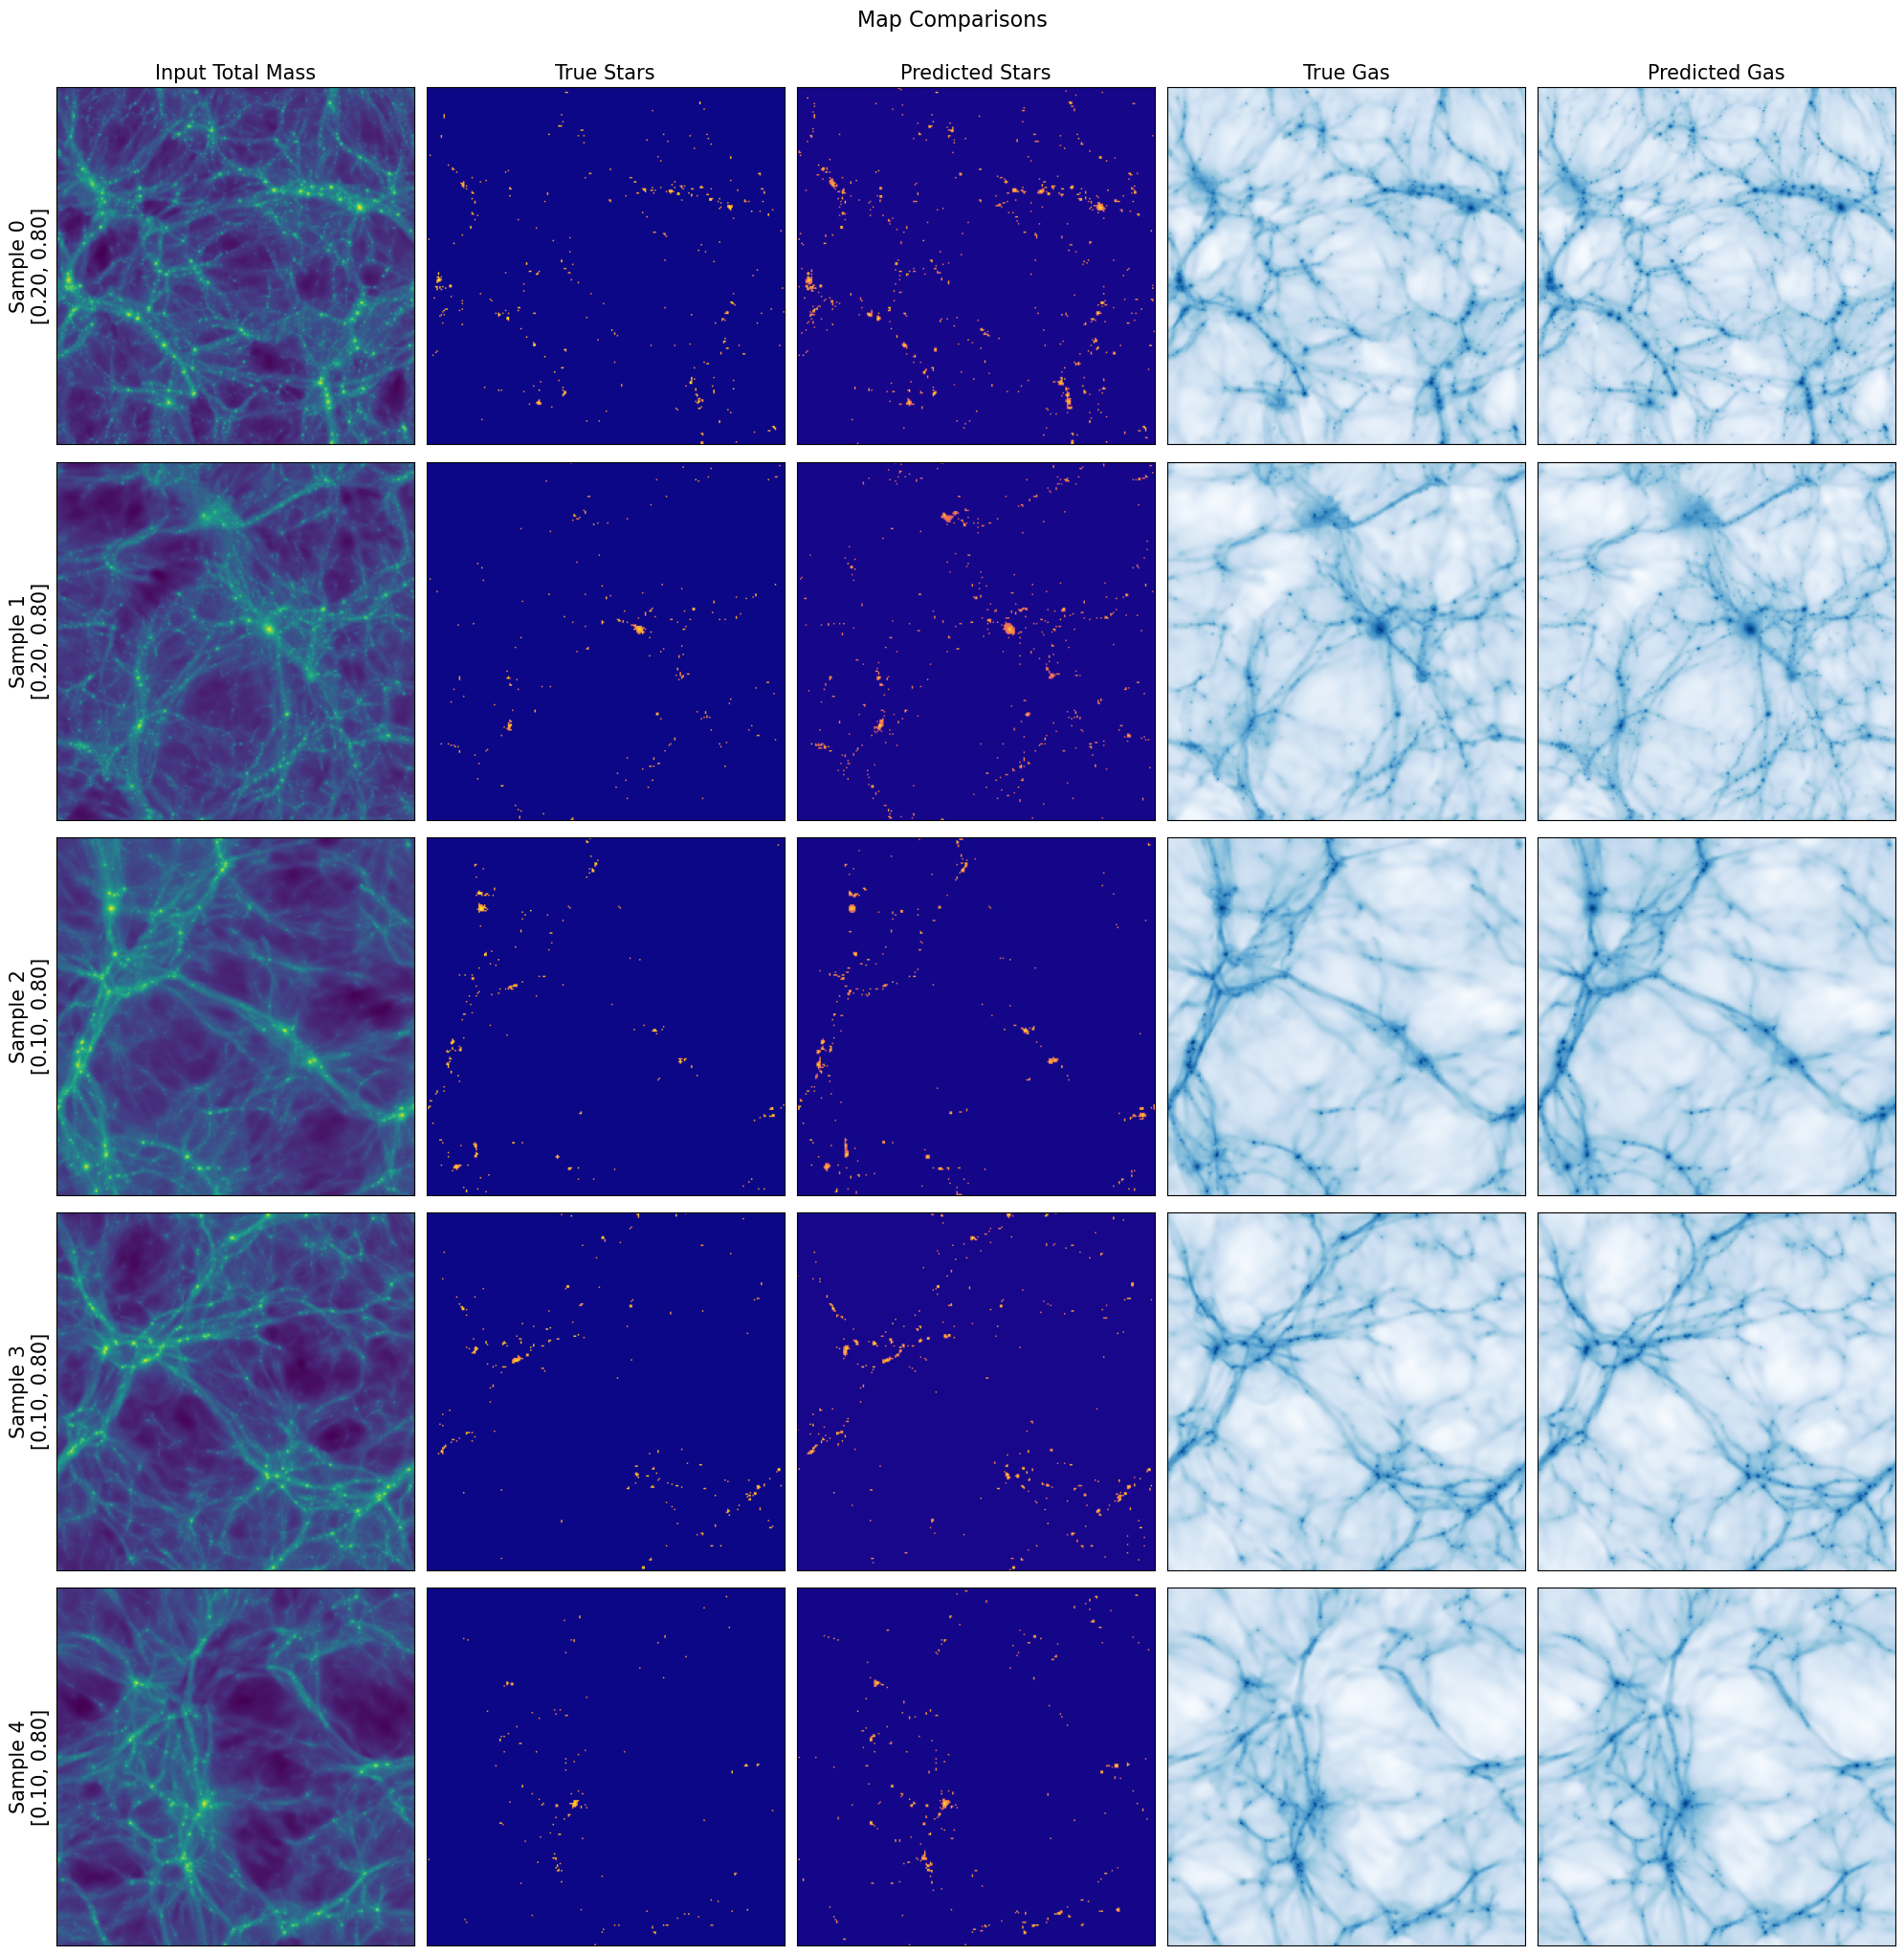

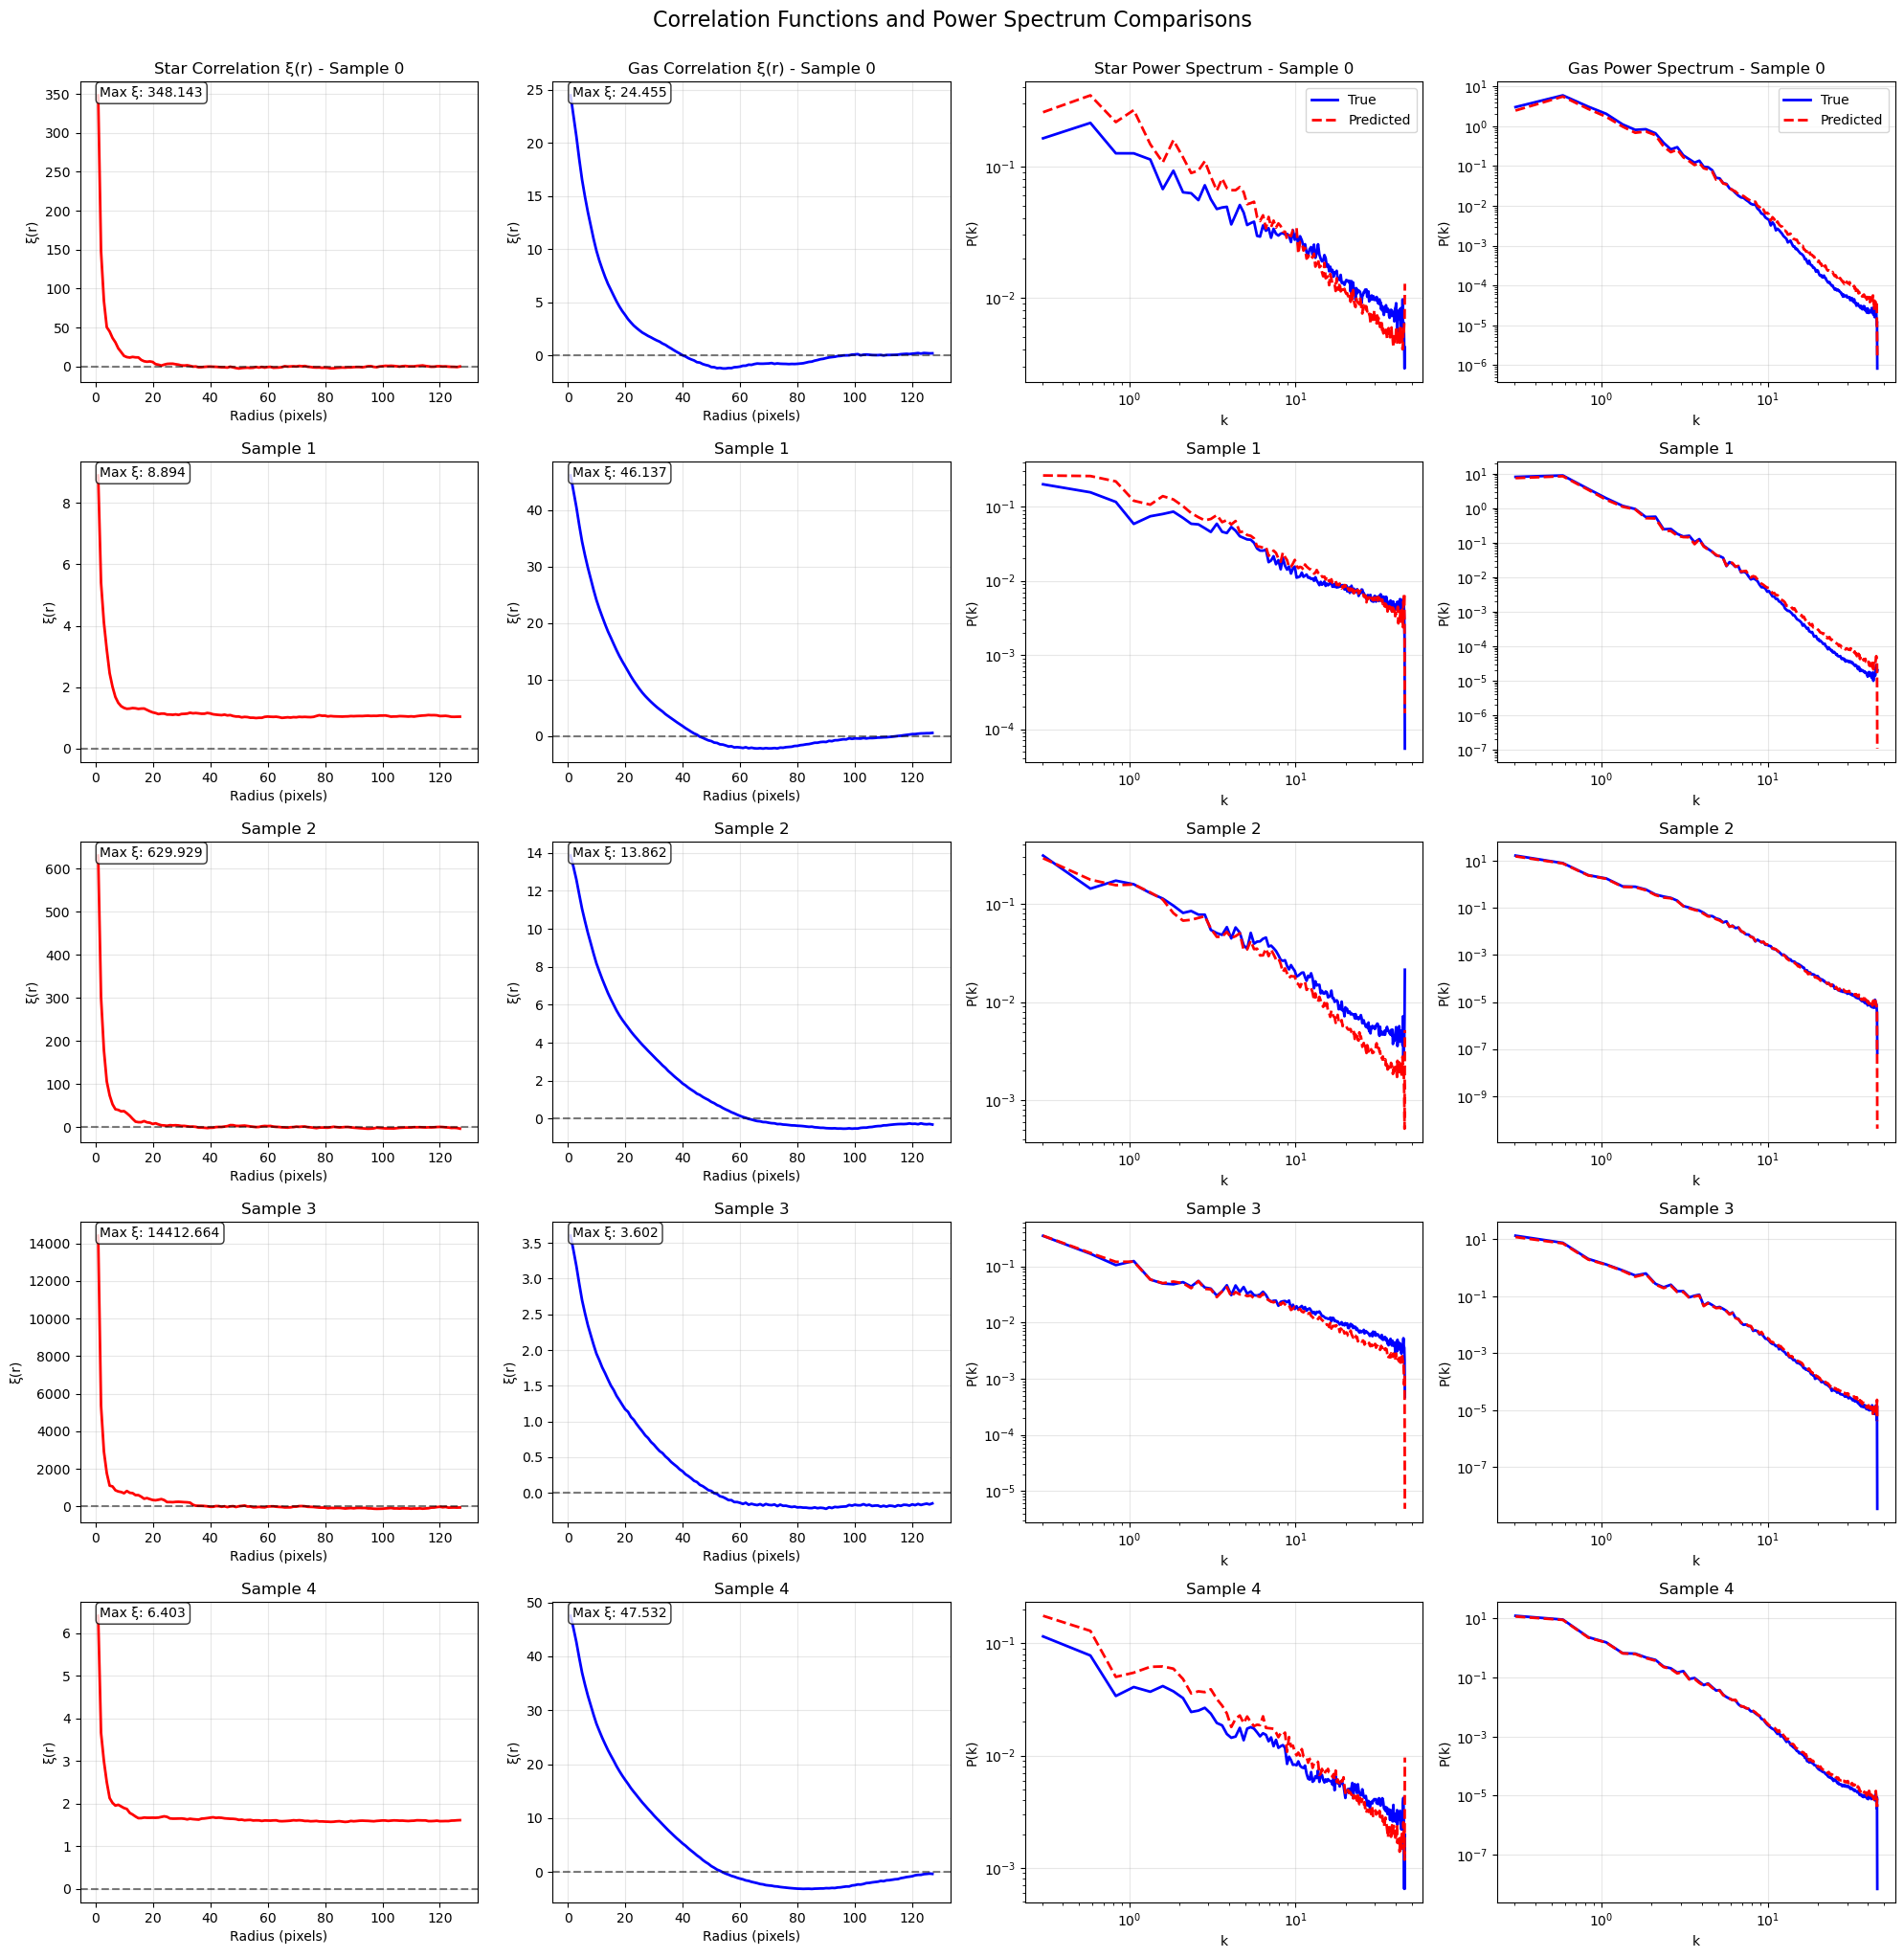

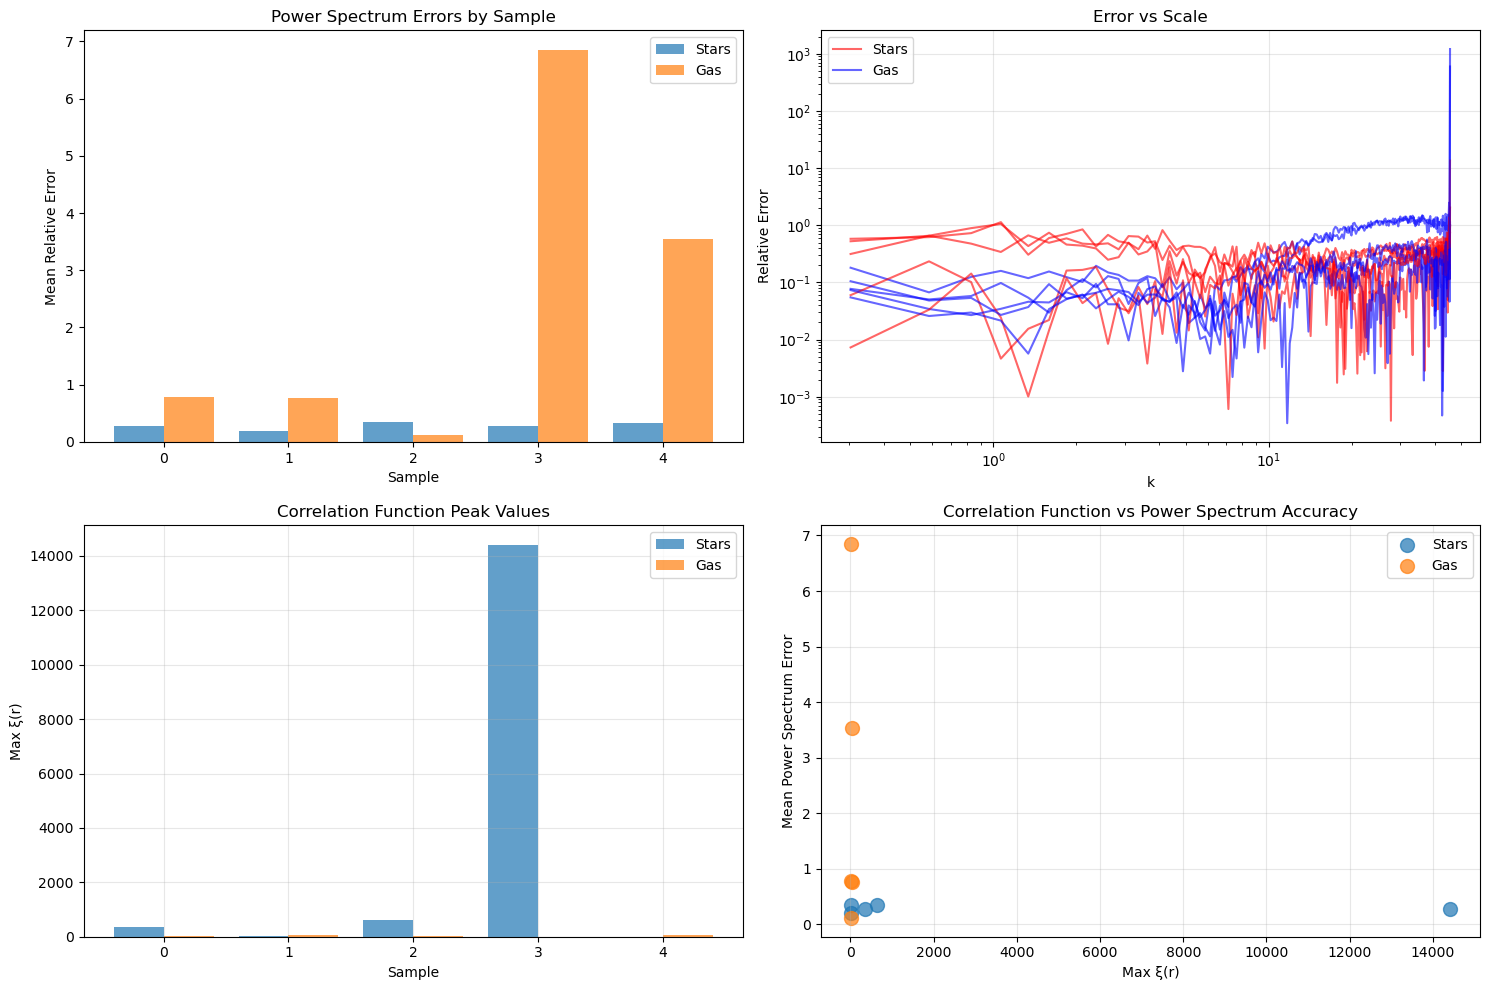

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from scipy.fft import fft2, ifft2, fftshift

def load_model(checkpoint_path):
    """Load trained flow matching model from checkpoint"""
    from module import FlowMatchingModel
    model = FlowMatchingModel.load_from_checkpoint(checkpoint_path)
    model.eval()
    return model

# Five sample analysis and visualization
def analyze_five_samples(checkpoint_path, total_mass_path, star_maps_path, gas_maps_path, params_path, num_steps=50):
    """Process 5 samples and create comprehensive visualizations"""
    
    # Load model
    model = load_model(checkpoint_path)
    model.eval()

    # Load data (first 5 samples)
    total_mass_maps = np.load(total_mass_path)
    # inds = random.sample(range(len(total_mass_maps)),5)
    inds = random.sample(range(30),5)
    
    total_mass_maps = total_mass_maps[inds]
    star_maps = np.load(star_maps_path)[inds] 
    gas_maps = np.load(gas_maps_path)[inds]
    astro_params = np.loadtxt(params_path)[:,:2]  # Condition on Ωm and σ8
    astro_params = np.repeat(astro_params, 15, axis=0)  # Repeat for 15 samples
    astro_params = astro_params[inds]

    
    # Apply log transform
    total_mass_log = np.log1p(total_mass_maps)
    star_maps_log = np.log1p(star_maps)
    gas_maps_log = np.log1p(gas_maps)
    
    # Normalize (use simple normalization)
    tot_mean, tot_std = total_mass_log.mean(), total_mass_log.std()
    total_mass_norm = (total_mass_log - tot_mean) / tot_std

    star_mean, star_std = star_maps_log.mean(), star_maps_log.std()
    star_maps_norm = (star_maps_log - star_mean) / star_std

    gas_mean,gas_std =gas_maps_log.mean(),gas_maps_log.std()
    gas_maps_norm = (gas_maps_log -gas_mean) /gas_std

    total_mass_log_noisy = total_mass_log + random.normal(loc=0.0,scale=0.2,size=total_mass_log.shape)
    
    # Create dataset and dataloader
    from utils import AstroMapDataset
    from torch.utils.data import DataLoader

    dummy_maps = np.zeros(total_mass_log_noisy.shape)

    # Dummy in place of star and gas for inference
    dataset = AstroMapDataset(total_mass_log, dummy_maps, dummy_maps, astro_params)
    dataloader = DataLoader(dataset, batch_size=5, shuffle=False)
    
    # Generate predictions
    device = next(model.parameters()).device
    with torch.no_grad():
        for batch in dataloader:
            total_mass_batch, _, params_batch = batch
            total_mass_batch = total_mass_batch.to(device)
            params_batch = params_batch.to(device)
            
            predictions = model.sample(
                total_mass=total_mass_batch,
                astro_params=params_batch,
                total_mass_condition=total_mass_batch,
                num_steps=num_steps,
                method='euler'
            )
            predictions = predictions.cpu().numpy()
            break
    
    # Compute power spectra
    star_pk_results = []
    gas_pk_results = []
    
    for i in range(5):
        # Star maps
        k_star_pred, pk_star_pred = get_pk(predictions[i, 0])
        k_star_true, pk_star_true = get_pk(star_maps_norm[i])
        star_pk_results.append({
            'k': k_star_pred,
            'pk_pred': pk_star_pred,
            'pk_true': pk_star_true,
            'error': np.abs(pk_star_pred - pk_star_true) / pk_star_true
        })
        
        # Gas maps  
        k_gas_pred, pk_gas_pred = get_pk(predictions[i, 1])
        k_gas_true, pk_gas_true = get_pk(gas_maps_norm[i])
        gas_pk_results.append({
            'k': k_gas_pred,
            'pk_pred': pk_gas_pred,
            'pk_true': pk_gas_true,
            'error': np.abs(pk_gas_pred - pk_gas_true) / pk_gas_true
        })
    
    # Create visualizations
    plot_five_samples(total_mass_norm, predictions, star_maps_norm, gas_maps_norm, 
                     astro_params, star_pk_results, gas_pk_results)
    
    return predictions, star_pk_results, gas_pk_results

def plot_five_samples(total_mass, predictions, true_star_maps, true_gas_maps, 
                     astro_params, star_pk_results, gas_pk_results):
    """Create comprehensive plots for 5 samples with 1D correlation analysis"""
    
    # 1. Map comparison grid (5x5)
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    
    for i in range(5):
        # Input total mass
        im0 = axes[i,0].imshow(total_mass[i], cmap='viridis')
        axes[i,0].set_title('Input Total Mass' if i==0 else '', fontsize=15)
        
        # True star
        im1 = axes[i,1].imshow(true_star_maps[i], cmap='plasma')
        axes[i,1].set_title('True Stars' if i==0 else '', fontsize=15)
        
        # Predicted star  
        im2 = axes[i,2].imshow(predictions[i,0], cmap='plasma')
        axes[i,2].set_title('Predicted Stars' if i==0 else '', fontsize=15)
        
        # True gas
        im3 = axes[i,3].imshow(true_gas_maps[i], cmap='Blues')
        axes[i,3].set_title('True Gas' if i==0 else '', fontsize=15)
        
        # Predicted gas
        im4 = axes[i,4].imshow(predictions[i,1], cmap='Blues')
        axes[i,4].set_title('Predicted Gas' if i==0 else '', fontsize=15)
        
        # Remove ticks
        for ax in axes[i]:
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Add parameter info
        param_str = f"Sample {i}\n[{', '.join(f'{p:.2f}' for p in astro_params[i])}]"
        axes[i,0].set_ylabel(param_str, fontsize=15)
    
    plt.tight_layout()
    plt.suptitle('Map Comparisons', fontsize=16, y=1.02)
    plt.savefig('grid.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 2. Combined Correlation function and Power spectrum comparisons (5x4 grid)
    fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    
    star_corr_results = []
    gas_corr_results = []
    
    for i in range(5):
        # Column 1: Star correlation function ξ(r)
        r_star, xi_star = get_xcorr(predictions[i,0], true_star_maps[i])
        star_corr_results.append({'r': r_star, 'xi': xi_star})
        
        axes[i,0].plot(r_star, xi_star, 'r-', linewidth=2, label='ξ(r)')
        axes[i,0].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[i,0].set_title(f'Star Correlation ξ(r) - Sample {i}' if i==0 else f'Sample {i}')
        axes[i,0].set_xlabel('Radius (pixels)')
        axes[i,0].set_ylabel('ξ(r)')
        axes[i,0].grid(True, alpha=0.3)
        
        # Add max correlation value
        max_xi_star = np.max(xi_star) if len(xi_star) > 0 else 0
        axes[i,0].text(0.05, 0.95, f'Max ξ: {max_xi_star:.3f}', 
                      transform=axes[i,0].transAxes, fontsize=10,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Column 2: Gas correlation function ξ(r)
        r_gas, xi_gas = get_xcorr(predictions[i,1], true_gas_maps[i])
        gas_corr_results.append({'r': r_gas, 'xi': xi_gas})
        
        axes[i,1].plot(r_gas, xi_gas, 'b-', linewidth=2, label='ξ(r)')
        axes[i,1].axhline(y=0, color='k', linestyle='--', alpha=0.5)
        axes[i,1].set_title(f'Gas Correlation ξ(r) - Sample {i}' if i==0 else f'Sample {i}')
        axes[i,1].set_xlabel('Radius (pixels)')
        axes[i,1].set_ylabel('ξ(r)')
        axes[i,1].grid(True, alpha=0.3)
        
        # Add max correlation value
        max_xi_gas = np.max(xi_gas) if len(xi_gas) > 0 else 0
        axes[i,1].text(0.05, 0.95, f'Max ξ: {max_xi_gas:.3f}', 
                      transform=axes[i,1].transAxes, fontsize=10,
                      bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Column 3: Star power spectra
        axes[i,2].loglog(star_pk_results[i]['k'], star_pk_results[i]['pk_true'], 
                        'b-', label='True', linewidth=2)
        axes[i,2].loglog(star_pk_results[i]['k'], star_pk_results[i]['pk_pred'], 
                        'r--', label='Predicted', linewidth=2)
        axes[i,2].set_title(f'Star Power Spectrum - Sample {i}' if i==0 else f'Sample {i}')
        axes[i,2].set_xlabel('k')
        axes[i,2].set_ylabel('P(k)')
        if i == 0:
            axes[i,2].legend()
        axes[i,2].grid(True, alpha=0.3)
        
        # Column 4: Gas power spectra
        axes[i,3].loglog(gas_pk_results[i]['k'], gas_pk_results[i]['pk_true'], 
                        'b-', label='True', linewidth=2)
        axes[i,3].loglog(gas_pk_results[i]['k'], gas_pk_results[i]['pk_pred'], 
                        'r--', label='Predicted', linewidth=2)
        axes[i,3].set_title(f'Gas Power Spectrum - Sample {i}' if i==0 else f'Sample {i}')
        axes[i,3].set_xlabel('k')
        axes[i,3].set_ylabel('P(k)')
        if i == 0:
            axes[i,3].legend()
        axes[i,3].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Correlation Functions and Power Spectrum Comparisons', fontsize=16, y=1.02)
    plt.savefig('combined_correlation_and_pk.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # 3. Enhanced error summary with correlation function metrics
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Mean errors per sample
    star_mean_errors = [np.mean(result['error']) for result in star_pk_results]
    gas_mean_errors = [np.mean(result['error']) for result in gas_pk_results]
    
    x = range(5)
    axes[0,0].bar([i-0.2 for i in x], star_mean_errors, 0.4, label='Stars', alpha=0.7)
    axes[0,0].bar([i+0.2 for i in x], gas_mean_errors, 0.4, label='Gas', alpha=0.7)
    axes[0,0].set_xlabel('Sample')
    axes[0,0].set_ylabel('Mean Relative Error')
    axes[0,0].set_title('Power Spectrum Errors by Sample')
    axes[0,0].legend()
    axes[0,0].set_xticks(x)
    
    # Error vs k for all samples
    for i in range(5):
        axes[0,1].loglog(star_pk_results[i]['k'], star_pk_results[i]['error'], 
                        'r-', alpha=0.6, label='Stars' if i==0 else '')
        axes[0,1].loglog(gas_pk_results[i]['k'], gas_pk_results[i]['error'], 
                        'b-', alpha=0.6, label='Gas' if i==0 else '')
    
    axes[0,1].set_xlabel('k')
    axes[0,1].set_ylabel('Relative Error')
    axes[0,1].set_title('Error vs Scale')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Correlation function peak values
    star_xi_peaks = [np.max(result['xi']) if len(result['xi']) > 0 else 0 for result in star_corr_results]
    gas_xi_peaks = [np.max(result['xi']) if len(result['xi']) > 0 else 0 for result in gas_corr_results]
    
    axes[1,0].bar([i-0.2 for i in x], star_xi_peaks, 0.4, label='Stars', alpha=0.7)
    axes[1,0].bar([i+0.2 for i in x], gas_xi_peaks, 0.4, label='Gas', alpha=0.7)
    axes[1,0].set_xlabel('Sample')
    axes[1,0].set_ylabel('Max ξ(r)')
    axes[1,0].set_title('Correlation Function Peak Values')
    axes[1,0].legend()
    axes[1,0].set_xticks(x)
    axes[1,0].grid(True, alpha=0.3)
    
    # Correlation function vs Power Spectrum Error
    axes[1,1].scatter(star_xi_peaks, star_mean_errors, label='Stars', alpha=0.7, s=100)
    axes[1,1].scatter(gas_xi_peaks, gas_mean_errors, label='Gas', alpha=0.7, s=100)
    axes[1,1].set_xlabel('Max ξ(r)')
    axes[1,1].set_ylabel('Mean Power Spectrum Error')
    axes[1,1].set_title('Correlation Function vs Power Spectrum Accuracy')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('enhanced_error_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

# Usage
predictions, star_results, gas_results = analyze_five_samples(
    checkpoint_path='/n/netscratch/iaifi_lab/Lab/msliu/flow_COND/lightning_logs/tng_2param/checkpoints/best-model-epoch=118-val_loss=0.022059.ckpt',
    total_mass_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_1P_z=0.00.npy',
    star_maps_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_1P_z=0.00.npy',
    gas_maps_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_1P_z=0.00.npy',
    params_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt',
    num_steps=50
)

<>:135: SyntaxWarning: invalid escape sequence '\s'
<>:144: SyntaxWarning: invalid escape sequence '\s'
<>:135: SyntaxWarning: invalid escape sequence '\s'
<>:144: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_2444307/2198930131.py:135: SyntaxWarning: invalid escape sequence '\s'
  '--', color='gray', label='$\sigma=0.2$' if i == 0 and j==0 else None)
/tmp/ipykernel_2444307/2198930131.py:144: SyntaxWarning: invalid escape sequence '\s'
  '--', color='gray', label='$\sigma=0.2$' if i == 0 and j==0 else None)



Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time taken = 0.00 seconds

Computing power spectra of the fields...
Time FFTS = 0.00
Time loop = 0.00
Time t

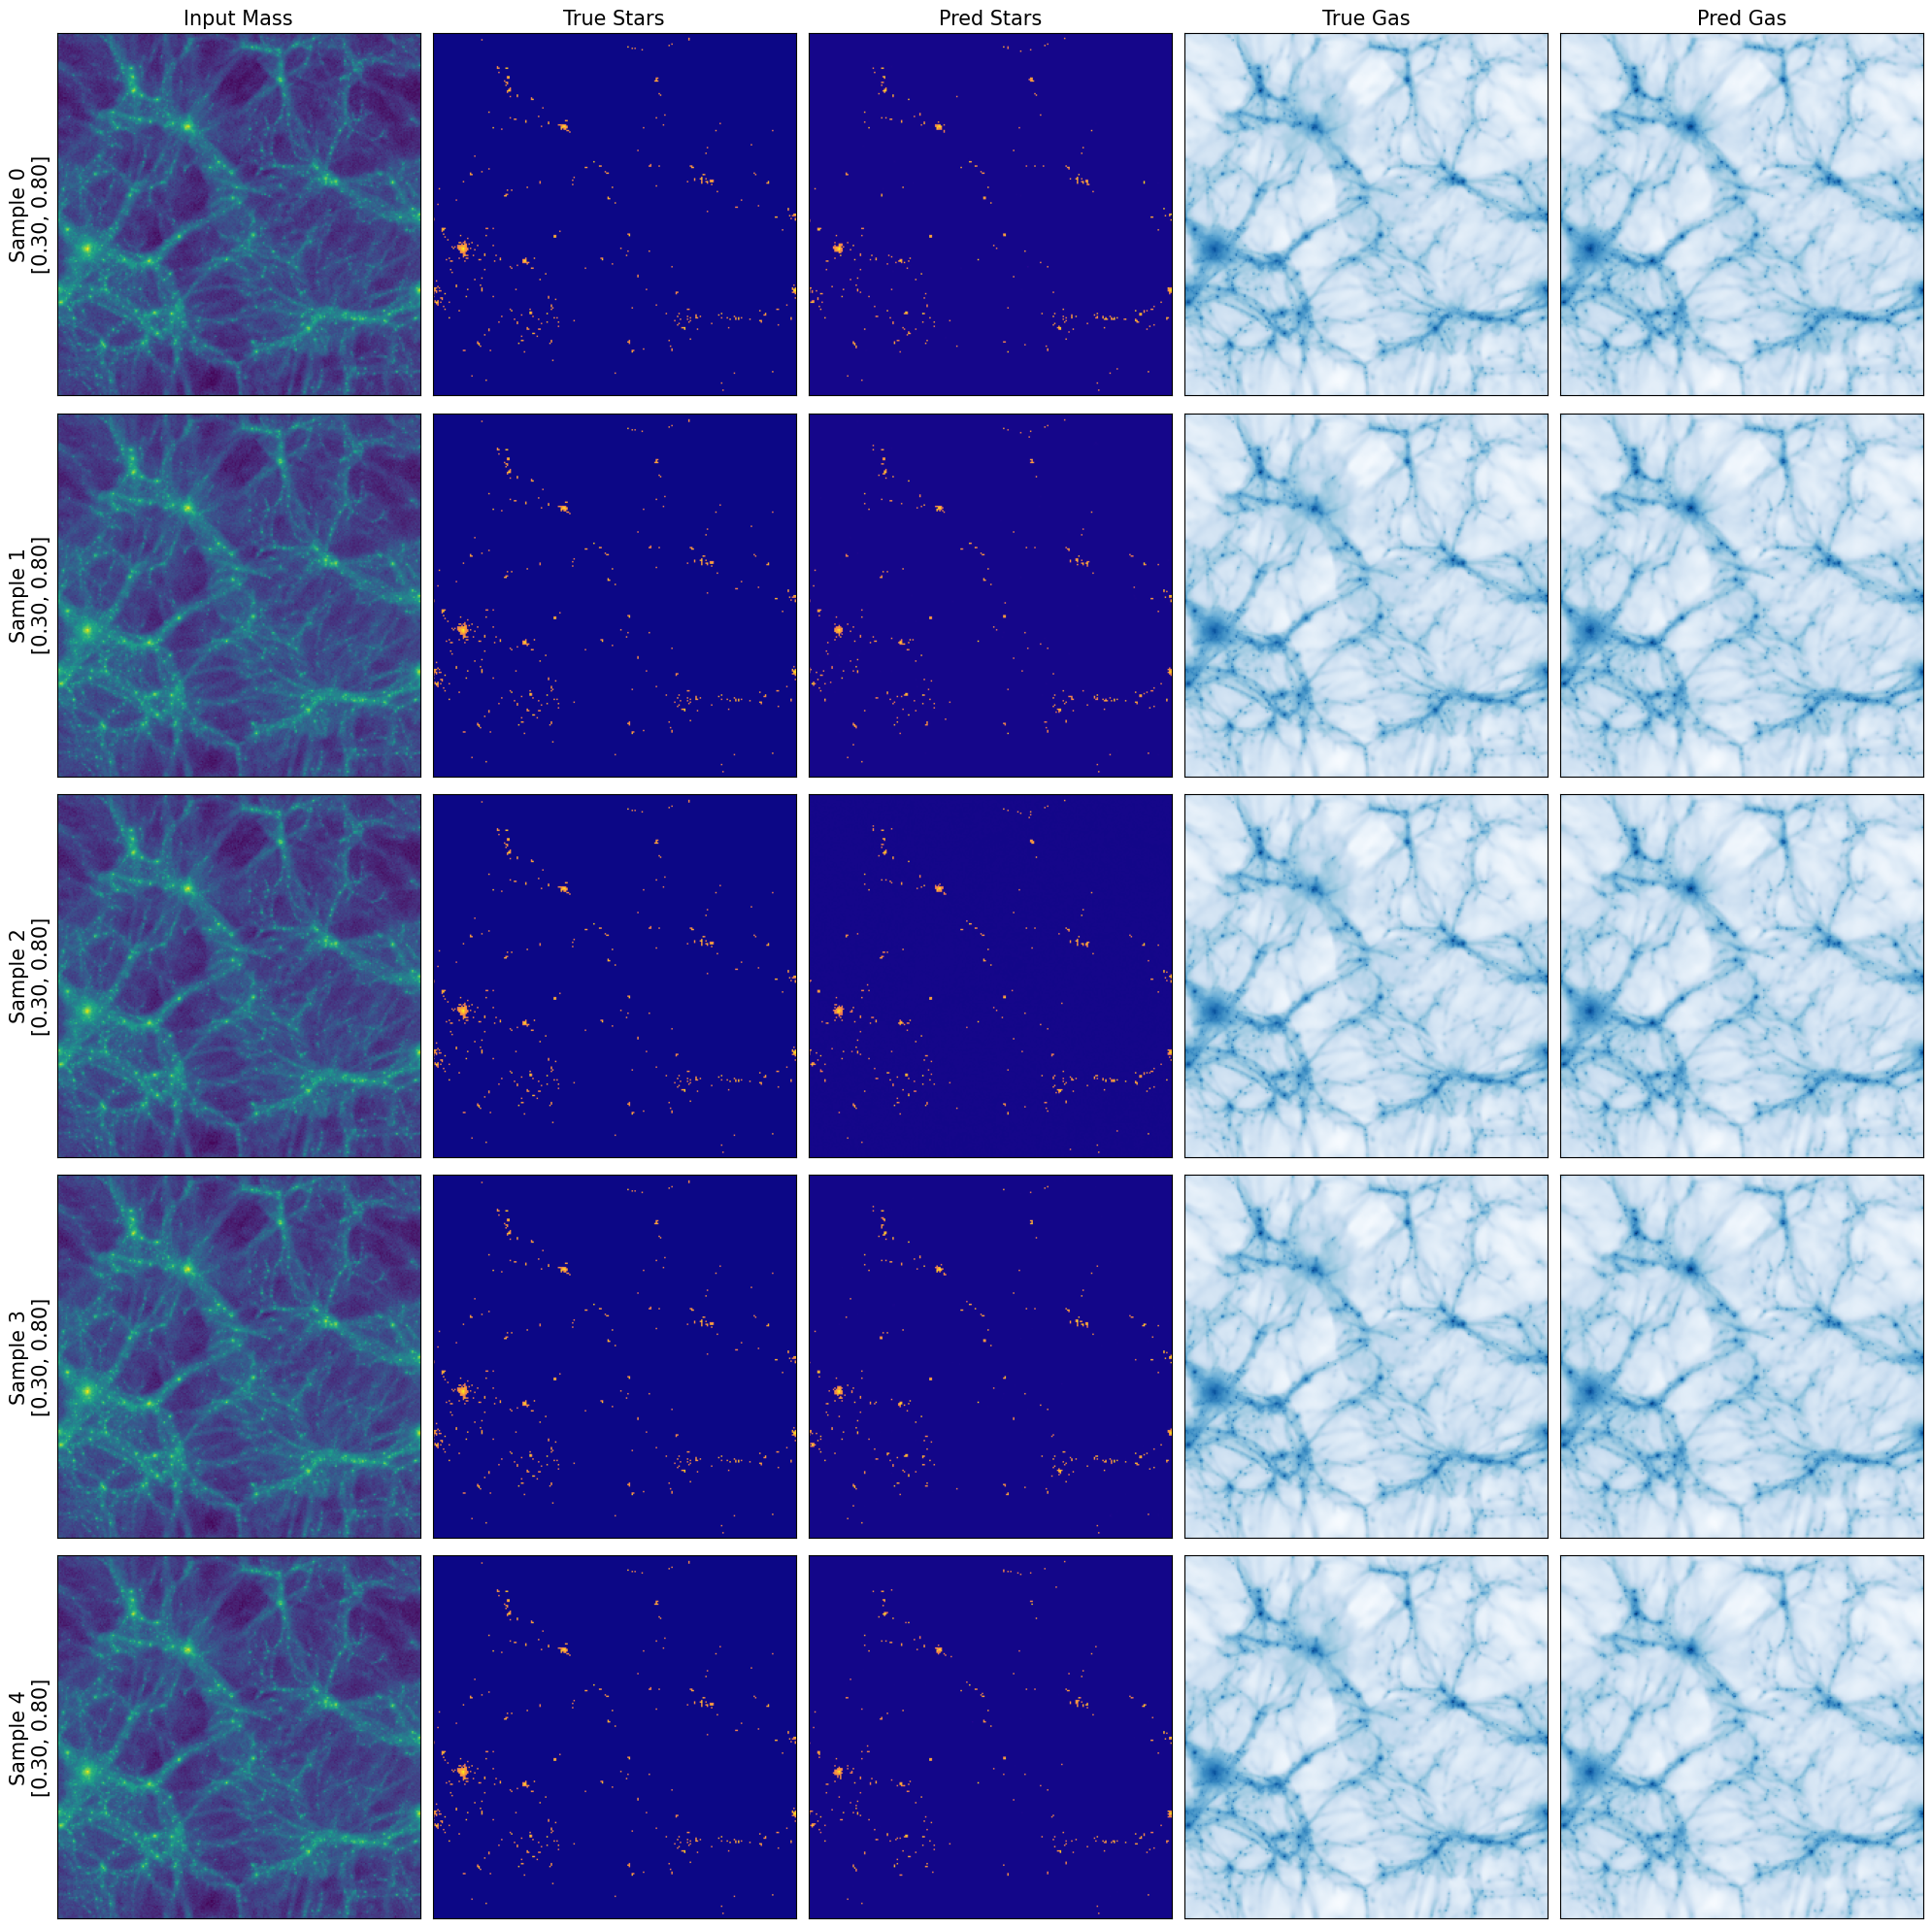

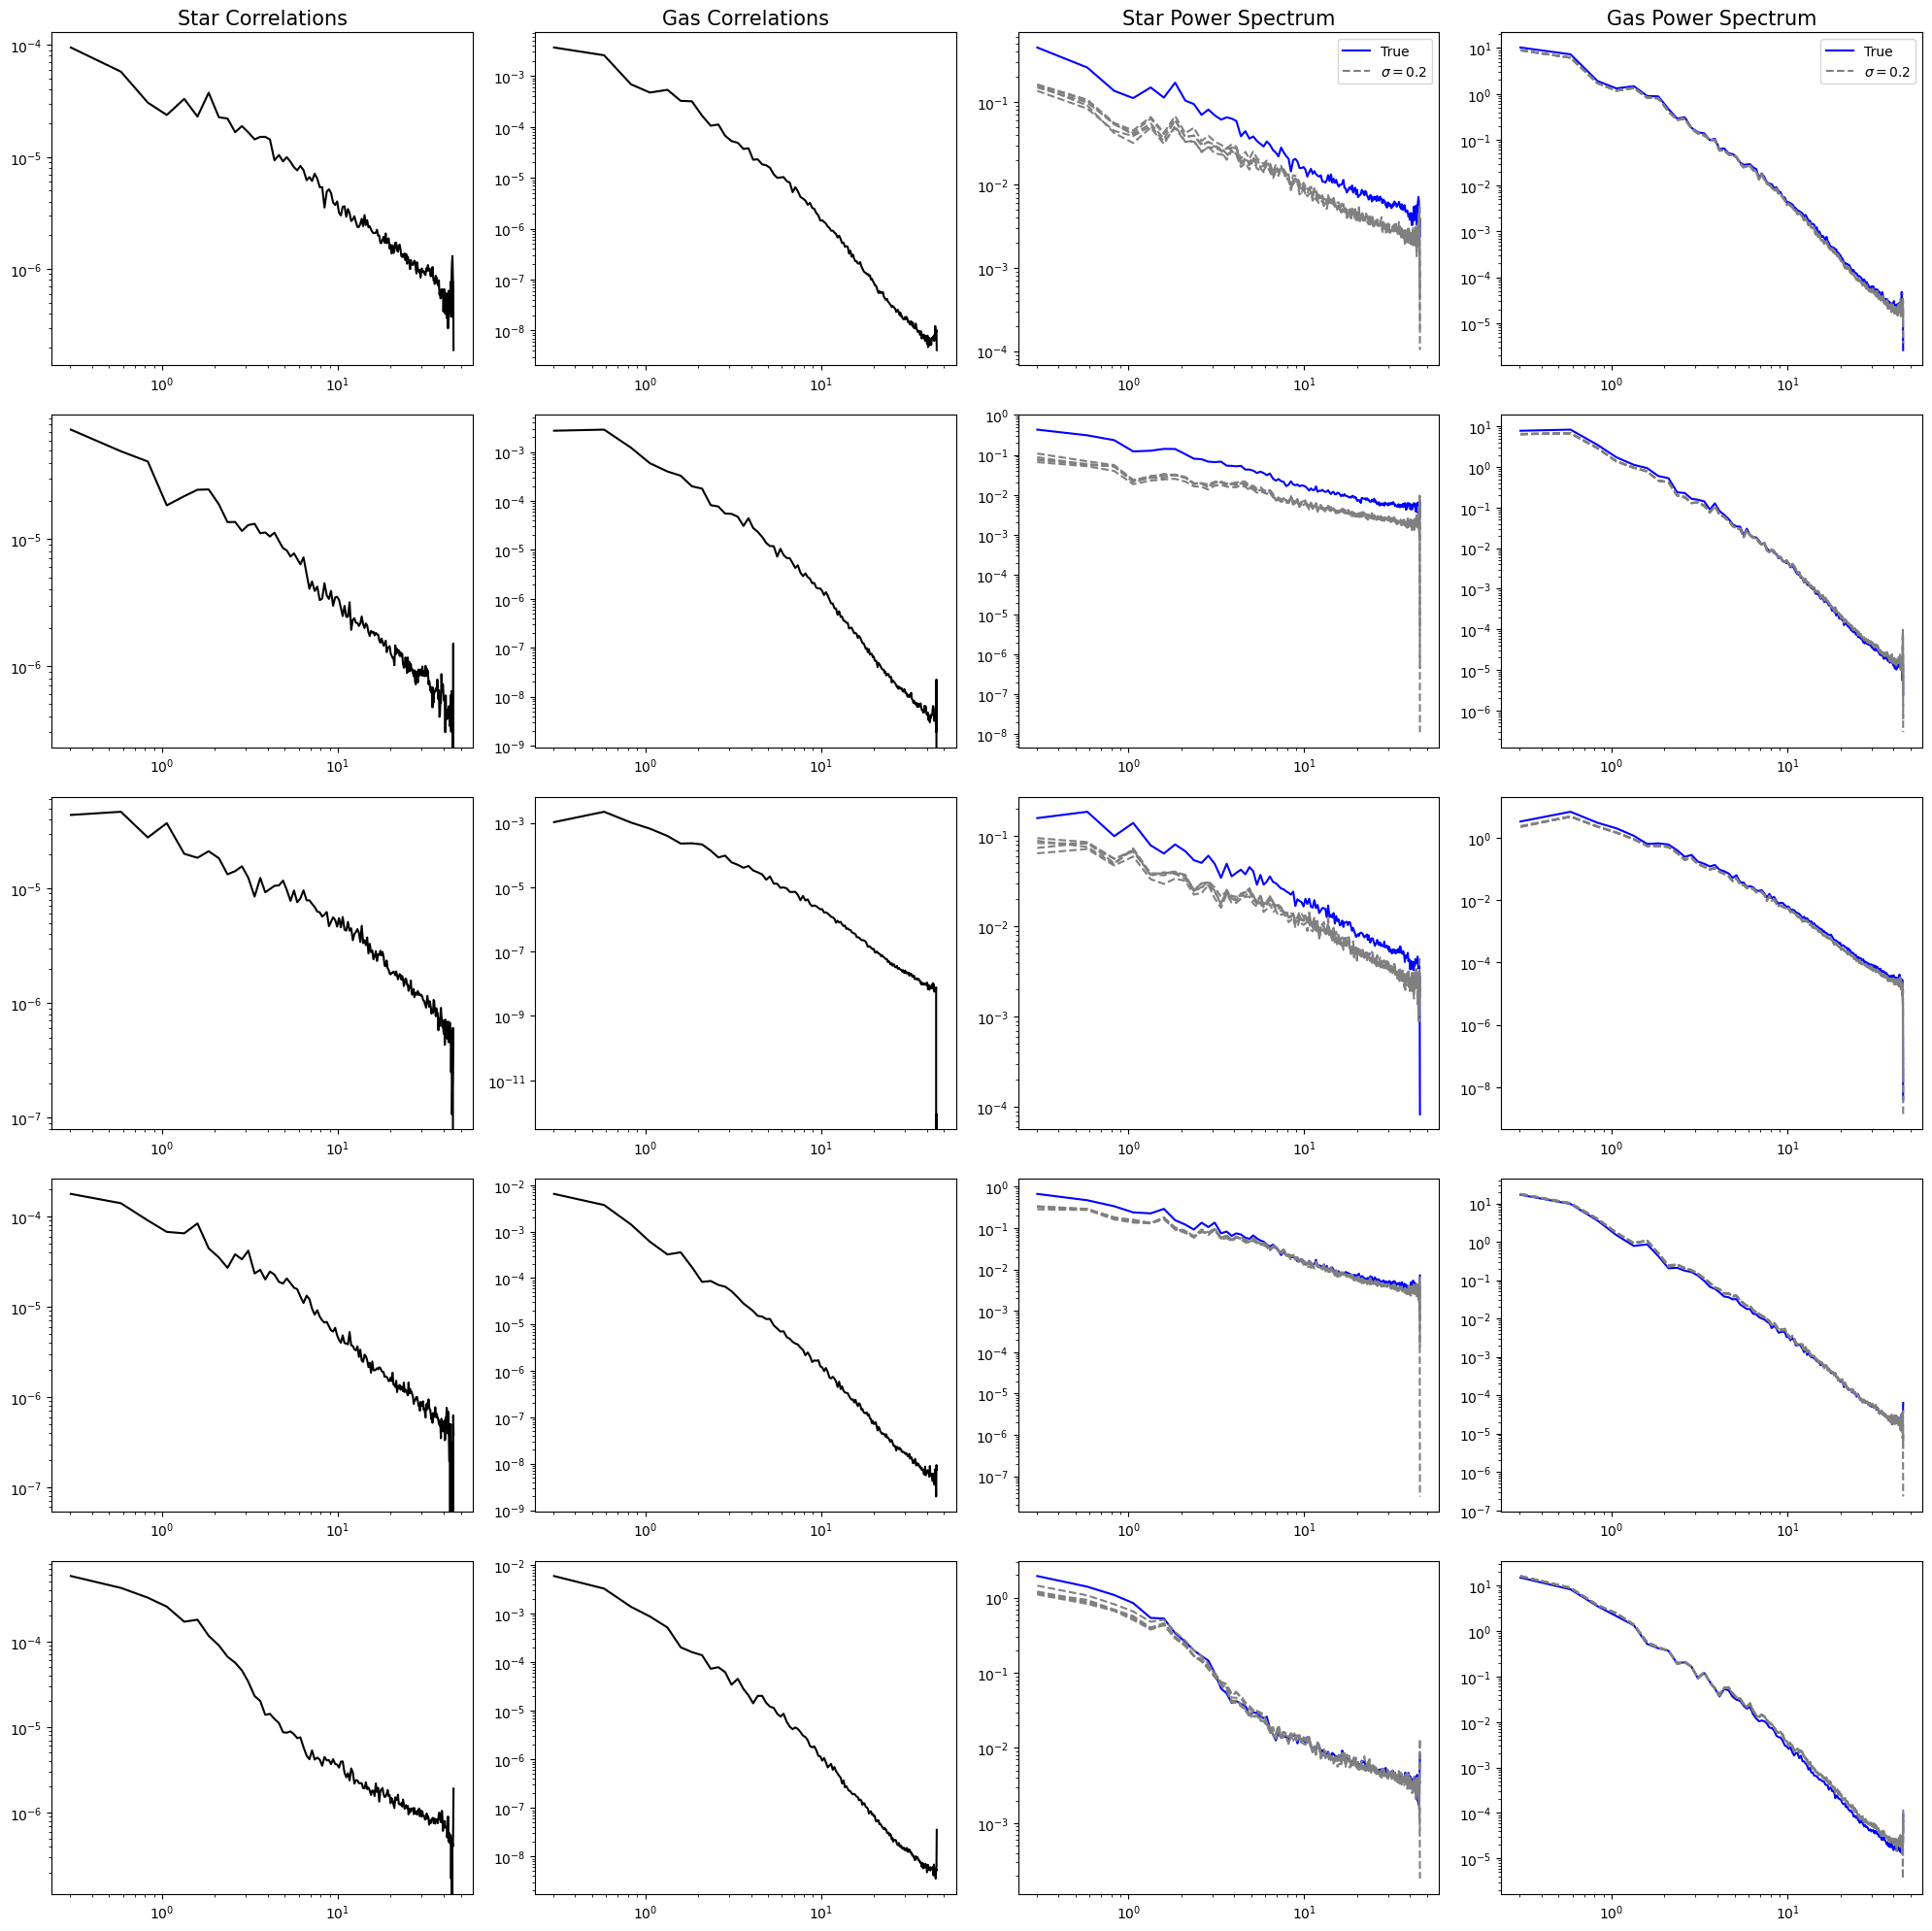

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from scipy.fft import fft2, ifft2, fftshift

# =========================================================
# Model loading + single-sample inference
# =========================================================
def load_model(checkpoint_path, device=None):
    """Load trained flow matching model from checkpoint"""
    from module import FlowMatchingModel
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = FlowMatchingModel.load_from_checkpoint(checkpoint_path, map_location=device)
    model.to(device)
    model.eval()
    return model, device

# =========================================================
# Main plotting for 5 samples
# =========================================================
def analyze_and_plot_five_samples(checkpoint_path,
                                  total_mass_path, star_maps_path, gas_maps_path, params_path,
                                  num_steps=50):
    model, device = load_model(checkpoint_path)

    # Stats for normalization
    total_mass_maps = np.load(total_mass_path)
    tot = np.log1p(total_mass_maps)
    tot_mean, tot_std = tot.mean(), tot.std()
    data_stats = {'tot_mean': tot_mean, 'tot_std': tot_std}

    indices = random.sample(range(len(total_mass_maps)), 5)

    preds_all, stars_true_all, gas_true_all, tot_mass_all, params_list_all = [], [], [], [], []
    star_pk_results, gas_pk_results = [], []
    star_corr_results, gas_corr_results = [], []

    for idx in indices:
        # Clean condition map
        sample_tot = np.log1p(total_mass_maps[idx])
        sample_tot_norm = (sample_tot - data_stats['tot_mean']) / data_stats['tot_std']

        # Noisy x0 maps
        noisy_tot_list = [
            sample_tot_norm + np.random.normal(loc=0, scale=0.2, size=(256, 256))
            for _ in range(5)
        ]

        # Load truth maps (norm by their own mean/std as before)
        star_map = np.log1p(np.load(star_maps_path)[idx])
        gas_map = np.log1p(np.load(gas_maps_path)[idx])
        star_map_norm = (star_map - star_map.mean()) / star_map.std()
        gas_map_norm = (gas_map - gas_map.mean()) / gas_map.std()
        astro_params = np.loadtxt(params_path)[idx//15, :2]

        # Repeat for each noisy version
        for noisy_tot in noisy_tot_list:
            total_mass_tensor = torch.tensor(noisy_tot, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            cond_tensor = torch.tensor(sample_tot_norm, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
            params_tensor = torch.tensor(astro_params, dtype=torch.float32).unsqueeze(0).to(device)

            with torch.no_grad():
                pred = model.sample(
                    total_mass=total_mass_tensor,
                    astro_params=params_tensor,
                    total_mass_condition=cond_tensor,
                    num_steps=num_steps,
                    method='euler'
                ).cpu().numpy()[0]

            preds_all.append(pred)
            stars_true_all.append(star_map_norm)
            gas_true_all.append(gas_map_norm)
            tot_mass_all.append(noisy_tot)
            params_list_all.append(astro_params)

            # Power spectrum + correlation
            k_star_pred, pk_star_pred = get_pk(pred[0])
            k_star_true, pk_star_true = get_pk(star_map_norm)
            star_pk_results.append({
                'k': k_star_pred,
                'pk_pred': pk_star_pred,
                'pk_true': pk_star_true,
                'error': np.abs(pk_star_pred - pk_star_true) / pk_star_true
            })

            k_gas_pred, pk_gas_pred = get_pk(pred[1])
            k_gas_true, pk_gas_true = get_pk(gas_map_norm)
            gas_pk_results.append({
                'k': k_gas_pred,
                'pk_pred': pk_gas_pred,
                'pk_true': pk_gas_true,
                'error': np.abs(pk_gas_pred - pk_gas_true) / pk_gas_true
            })

            r_star, xi_star = get_xcorr(pred[0], star_map_norm)
            r_gas, xi_gas = get_xcorr(pred[1], gas_map_norm)
            star_corr_results.append({'r': r_star, 'xi': xi_star})
            gas_corr_results.append({'r': r_gas, 'xi': xi_gas})

    # Your plotting code here (adjusted for 5*5 = 25 rows if showing all noisy runs)

    # ---------- Plot maps ----------
    fig, axes = plt.subplots(5, 5, figsize=(20, 20))
    for i in range(5):
        axes[i,0].imshow(tot_mass_all[i], cmap='viridis'); axes[i,0].set_title('Input Mass' if i==0 else '',fontsize=15)
        axes[i,1].imshow(stars_true_all[i], cmap='plasma'); axes[i,1].set_title('True Stars' if i==0 else '',fontsize=15)
        axes[i,2].imshow(preds_all[i][0], cmap='plasma'); axes[i,2].set_title('Pred Stars' if i==0 else '',fontsize=15)
        axes[i,3].imshow(gas_true_all[i], cmap='Blues'); axes[i,3].set_title('True Gas' if i==0 else '',fontsize=15)
        axes[i,4].imshow(preds_all[i][1], cmap='Blues'); axes[i,4].set_title('Pred Gas' if i==0 else '',fontsize=15)
        for ax in axes[i]: ax.set_xticks([]); ax.set_yticks([])
        axes[i,0].set_ylabel(f"Sample {i}\n[{', '.join(f'{p:.2f}' for p in params_list_all[i])}]", fontsize=15)
    plt.tight_layout()
    plt.savefig('grid.png', dpi=150)
    plt.show()

        # ---------- Plot correlations + P(k) ----------
    fig, axes = plt.subplots(5, 4, figsize=(20, 20))
    for i in range(5):
        # Each sample has 5 noisy runs
        base_idx = i * 5
        axes[i,0].loglog(star_corr_results[base_idx]['r'], star_corr_results[base_idx]['xi'], 'k-', label='Truth corr')  # just a placeholder label
        axes[i,0].set_title('Star Correlations' if i==0 else '', fontsize=15)
        axes[i,1].loglog(gas_corr_results[base_idx]['r'], gas_corr_results[base_idx]['xi'], 'k-')
        axes[i,1].set_title('Gas Correlations' if i==0 else '', fontsize=15)
        # Star power spectra: plot truth once, all noisy preds
        k_true = star_pk_results[base_idx]['k']
        pk_true = star_pk_results[base_idx]['pk_true']
        axes[i,2].loglog(k_true, pk_true, 'b-', label='True')
        for j in range(5):
            idx_j = base_idx + j
            axes[i,2].loglog(star_pk_results[idx_j]['k'], star_pk_results[idx_j]['pk_pred'],
                             '--', color='gray', label='$\sigma=0.2$' if i == 0 and j==0 else None)
        axes[i,2].set_title('Star Power Spectrum' if i==0 else '', fontsize=15)
        # Gas power spectra
        k_true_gas = gas_pk_results[base_idx]['k']
        pk_true_gas = gas_pk_results[base_idx]['pk_true']
        axes[i,3].loglog(k_true_gas, pk_true_gas, 'b-', label='True')
        for j in range(5):
            idx_j = base_idx + j
            axes[i,3].loglog(gas_pk_results[idx_j]['k'], gas_pk_results[idx_j]['pk_pred'],
                             '--', color='gray', label='$\sigma=0.2$' if i == 0 and j==0 else None)
        axes[i,3].set_title('Gas Power Spectrum' if i==0 else '', fontsize=15)
        if i == 0:
            axes[i,2].legend()
            axes[i,3].legend()

    plt.tight_layout()
    plt.savefig('correlation_pk.png', dpi=150)
    plt.show()


# Usage
analyze_and_plot_five_samples(
    checkpoint_path='/n/netscratch/iaifi_lab/Lab/msliu/flow_COND/lightning_logs/tng_2param/checkpoints/best-model-epoch=118-val_loss=0.022059.ckpt',
    total_mass_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_1P_z=0.00.npy',
    star_maps_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mstar_IllustrisTNG_1P_z=0.00.npy',
    gas_maps_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mgas_IllustrisTNG_1P_z=0.00.npy',
    params_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt',
    num_steps=50
)

In [11]:
total_mass_path='/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/Maps_Mtot_IllustrisTNG_1P_z=0.00.npy'
total_mass_log = np.log1p(np.load(total_mass_path))
total_mass_log_noisy = total_mass_log + np.random.normal(loc=0.0,scale=0.2,size=total_mass_log.shape)


In [7]:
PARAM1P = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt')
PARAMLH = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_LH_IllustrisTNG.txt')


In [12]:
p = PARAM1P
q = PARAMLH

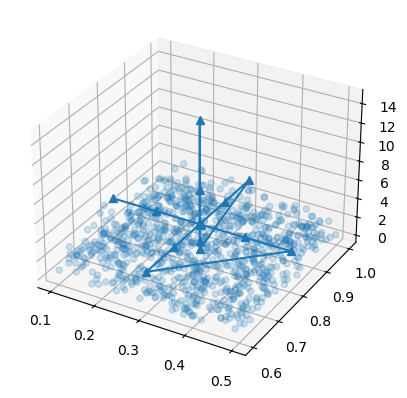

In [36]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.plot(p[:,0], p[:,1], p[:,2], marker='^')
ax.scatter(q[:,0], q[:,1], q[:,2], marker='o',alpha=0.2)


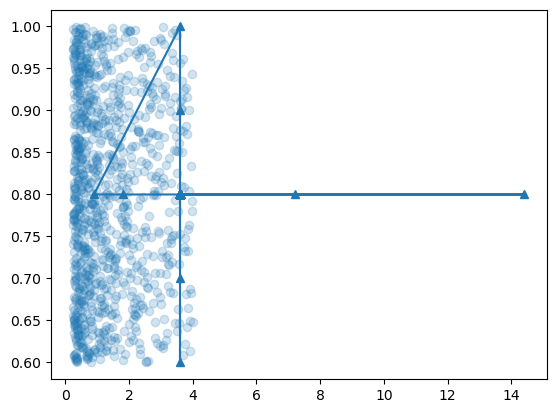

In [43]:
plt.plot(p[:,2], p[:,1], marker='^')
plt.scatter(q[:,2], q[:,1], marker='o',alpha=0.2)

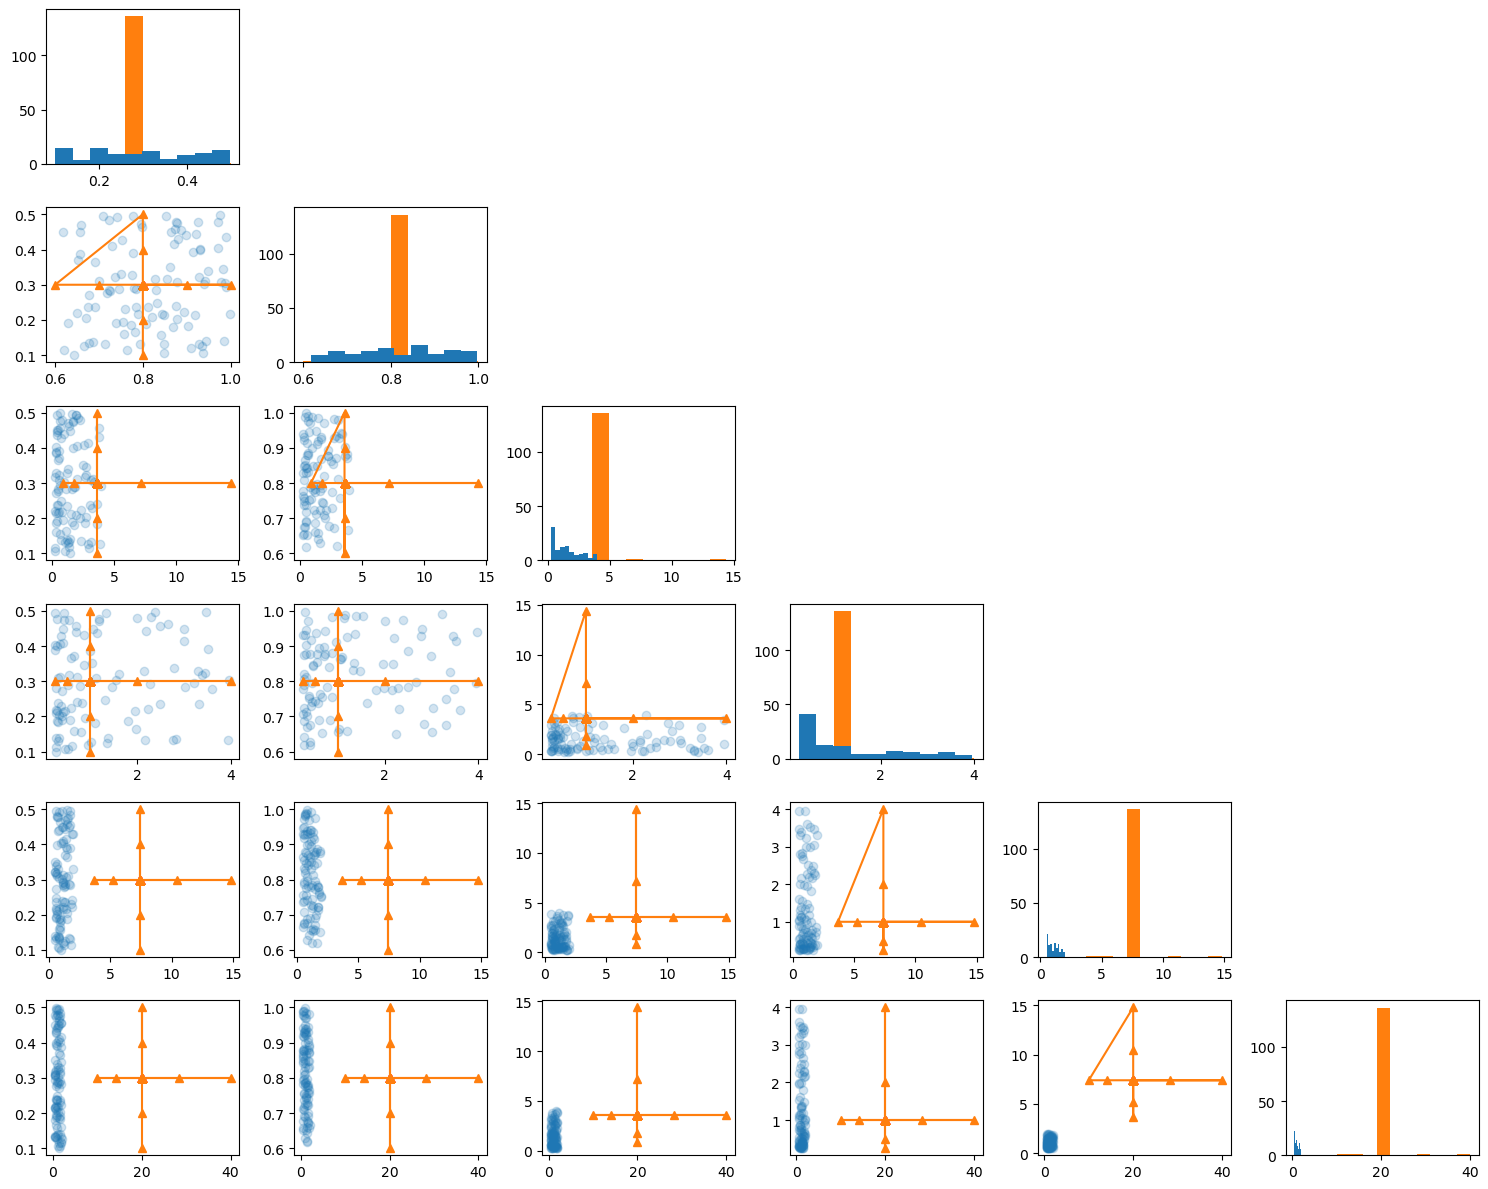

In [13]:
plt.figure(figsize=(15,12))

for i in range(6):
    for j in range(6):
        if i==j:
            plt.subplot(6,6,i*6+j+1)
            plt.hist(p[:,i],color='tab:orange')
            plt.hist(q[:,j])
        if i>j:
            plt.subplot(6,6,i*6+j+1)
            plt.plot(p[:,i], p[:,j], marker='^', color='tab:orange')
            plt.scatter(q[:,i], q[:,j], marker='o',alpha=0.2)
plt.tight_layout()
plt.savefig('param_comp.png')
plt.show()

In [54]:
plt.figure(figsize=(15,12))

for i in range(6):
    for j in range(6):
        if i==j:
            plt.subplot(6,6,i*6+j+1)
            plt.hist(p[:,i],color='tab:orange')
            plt.hist(q[:,j])
        if i>j:
            plt.subplot(6,6,i*6+j+1)
            plt.plot(p[:,i], p[:,j], marker='^', color='tab:orange')
            plt.scatter(q[:,i], q[:,j], marker='o',alpha=0.2)
plt.tight_layout()
plt.savefig('param_comp.png')
plt.show()

array([[ 0.1,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.2,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.3,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.4,  0.8,  3.6,  1. ,  7.4, 20. ],
       [ 0.5,  0.8,  3.6,  1. ,  7.4, 20. ]])

In [25]:
for i in range(28):
    print(PARAM1P[:,i].min(), PARAMSB28[:,i].min(), PARAM1P[:,i].max(), PARAMSB28[:,i].max())


0.1 0.10007 0.5 0.49984
0.6 0.60004 1.0 0.99981
0.9 0.90025 14.4 14.3972
0.25 0.25005 4.0 3.99657
3.7 3.70185 14.8 14.7915
10.0 10.0011 40.0 39.9821
0.029 0.02901 0.069 0.069
0.4711 0.47122 0.8711 0.87108
0.7624 0.76248 1.162 1.1622
1.135 1.13553 4.54 4.5375
0.1 0.10007 0.9 0.89985
-2.8 -2.79961 -1.8 -1.80036
4.0 4.00362 12.0 11.9976
0.025 0.02503 0.4 0.39965
0.0 0.596 4000.0 3998.18994
0.005 0.00501 0.5 0.49919
150.0 150.116 550.0 549.93298
0.0625 0.06258 1.0 0.99873
0.0005 0.0005 0.008 0.00799
1.0 1.00038 3.0 2.99927
0.2 0.20003 1.0 0.9997
3e-05 3e-05 0.00025 0.00025
0.25 0.25026 4.0 3.99925
0.1 0.10016 10.0 9.9994
0.025 0.02501 0.4 0.39981
0.05 0.05001 0.8 0.79902
6e-05 6e-05 0.0632 0.0632
0.0 0.00168 4.0 3.99836


In [21]:
for i in [0,1,3,22]:
    print(PARAM1P[:,i].min(), PARAM1P[:,i].max())


0.1 0.5
0.6 1.0
0.25 4.0
0.25 4.0


In [22]:
PARAM1P = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_1P_IllustrisTNG.txt')
PARAMSB28 = np.loadtxt('/n/netscratch/iaifi_lab/Lab/msliu/CMD/data/IllustrisTNG/params_SB28_IllustrisTNG.txt')


In [ ]:
for i in [0,1,3,22]:
    print(PARAM1P[:,i].min(), PARAM1P[:,i].max())
